#Deep Learning Project


Installing the jovian library and commiting all the work to my jovian profile.

In [2]:
!pip install jovian --upgrade --quiet

In [3]:
import jovian

In [4]:
# Execute this to save new versions of the notebook
jovian.commit(project="dl-p-1")

[jovian] Detected Colab notebook...
[jovian] Please enter your API key ( from https://jovian.ai/ ):
API KEY: ··········
[jovian] Uploading colab notebook to Jovian...
Committed successfully! https://jovian.ai/vijayraj-jain107130/dl-p-1


'https://jovian.ai/vijayraj-jain107130/dl-p-1'

Installing and importing the required libraries.

In [5]:
!pip install opendatasets --q

In [6]:
import opendatasets as od
import os
import shutil
import torch
import torchvision
import tarfile
import torch.nn as nn
import numpy as np
import pandas as pd
import torch.nn.functional as F
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torch.utils.data.sampler import WeightedRandomSampler
import torchvision.transforms as T
from torch.utils.data import random_split
from torchvision.utils import make_grid
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

matplotlib.rcParams['figure.facecolor'] = '#ffffff'

##Downloading and preparing the dataset for training

###Download the dataset

> Downloading the dataset from kaggle using `opendatasets` library.

In [7]:
od.download('https://www.kaggle.com/arpitjain007/game-of-deep-learning-ship-datasets')

100%|██████████| 80.9M/80.9M [00:00<00:00, 85.7MB/s]


List the directories in downloaded file.

In [8]:
data_dir = 'game-of-deep-learning-ship-datasets'
os.listdir(data_dir)

['sample_submission_ns2btKE.csv', 'test_ApKoW4T.csv', 'train']

Dataset should be inside the 'train' folder.

In [9]:
train_dir = data_dir + '/train'
os.listdir(train_dir)

['train.csv', 'images']

###Read the CSV file

>Reading the csv file using the `read_csv()` function from `pandas` library.

In [10]:
df = pd.read_csv(train_dir + '/train.csv')
df.head()

,image,category
0,2823080.jpg,1
1,2870024.jpg,1
2,2662125.jpg,2
3,2900420.jpg,3
4,2804883.jpg,2


CSV file contains the labels of all the images and 'images' folder contain all the images of different ships.

In [11]:
df['category'].unique() #print the unique categories present in the csv file

array([1, 2, 3, 4, 5])

Defining a dictionary of with category number as key and category name as value(based on the information provided about the dataset).


In [12]:
cat_name = {1:'cargo', 2:'military', 3:'carrier', 4:'cruise', 5:'tanker'}
cat_name

{1: 'cargo', 2: 'military', 3: 'carrier', 4: 'cruise', 5: 'tanker'}

Mapping the names with their respective categories using the map function .

In [13]:
df['name'] = df['category'].map(cat_name)
df.head()

,image,category,name
0,2823080.jpg,1,cargo
1,2870024.jpg,1,cargo
2,2662125.jpg,2,military
3,2900420.jpg,3,carrier
4,2804883.jpg,2,military


In [14]:
classes = df['name'].unique()

In [15]:
df['name'].value_counts() #print the number of images in each category

cargo       2120
tanker      1217
military    1167
carrier      916
cruise       832
Name: name, dtype: int64

###Separate the images

>Moving the images to subfolders of their respective category name.

In [16]:
for c in classes:          #creating a folder for each category
  os.makedirs(train_dir + '/catg_imgs/' + c)

for c in classes:
  for img in list(df[df['name']==c]['image']):             #get a list of all images belonging to a particular class
    get_image = os.path.join(train_dir + '/images', img)   #get the image from images folder
    shutil.move(get_image, train_dir+ '/catg_imgs/' + c)   #copy the images to the specified location

shutil.rmtree(train_dir + '/images')                       #after copying the images remove the 'images' folder to save memory space

In [17]:
for c in classes:
  l = len(os.listdir(train_dir+ '/catg_imgs/' + c))
  print(c + '  ',l)    #checking if the images are copied properly

cargo   2120
military   1167
carrier   916
cruise   832
tanker   1217


So, the images are copies properly but as it can be observed that there is a class imbalance, i.e., number of images for cruise and carrier category are very less compared to cargo. I'll use `class_sample_count` further to deal with the problem of imbalance.

###Import images as pytorch tensors

Using `ImageFolder` class from `torchvision` to load images as pytorch tensors.

In [18]:
dataset = ImageFolder(train_dir + '/catg_imgs')
len(dataset)

6252

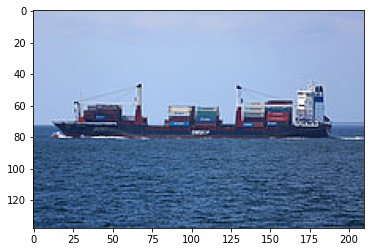

In [19]:
img, label = dataset[40]
plt.imshow(img)

###Data Augmentation

>Applying random transformations while loading images from the training dataset. Pad each image by 4 pixels, and then take a random crop of size 64 x 64 pixels, and change the brightness, contrast of the image, and then flip the image horizontally with a 50% probability. It will allow the model to generalize better.

In [20]:
#Applying certain transforms to the images

stats = ((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
tfms = T.Compose([T.Resize(64),
                  T.RandomCrop(64, padding=4, padding_mode='reflect'),
                  T.RandomHorizontalFlip(), 
                  T.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
                  T.ToTensor(), 
                  T.Normalize(*stats,inplace=True)])

dataset = ImageFolder(train_dir + '/catg_imgs', transform=tfms)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


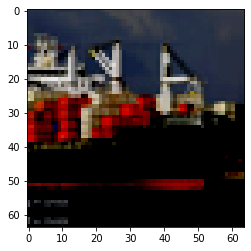

In [21]:
img, label = dataset[969]

plt.imshow(img.permute((1, 2, 0)))

###Split the dataset

>Splitting the dataset into training set and validation set using `random_split` from `torch.utils.data`.

In [22]:
val_pct = 0.1
val_size = int(len(dataset) * val_pct)
train_size = len(dataset) - val_size


train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(5627, 625)

###Create data loaders and handling imbalanced classes

> * Creating data loaders for training and validation to load the data in batches. Using `DataLoader` class from `torch.utils.data`.




In [23]:
batch_size = 128

# class_count = np.unique(df['category'], return_counts=True)[1]

# weights = 1. / class_count
# samples_weight = weights[df['category']-1]
# samples_weight = torch.from_numpy(samples_weight)
# sampler = WeightedRandomSampler(weights, len(samples_weight))

train_dl = DataLoader(train_ds, batch_size, num_workers=2, pin_memory=True) #, sampler=sampler)
valid_dl = DataLoader(val_ds, batch_size, num_workers=2, pin_memory=True)

In [24]:
def denormalize(images, means, stds):                   #Denormalize the images
    means = torch.tensor(means).reshape(1, 3, 1, 1)
    stds = torch.tensor(stds).reshape(1, 3, 1, 1)
    return images * stds + means

def show_batch(dl):                                     #Display the batch of images
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        denorm_images = denormalize(images, *stats)
        ax.imshow(make_grid(denorm_images[:16], nrow=4).permute(1, 2, 0).clamp(0,1))
        break

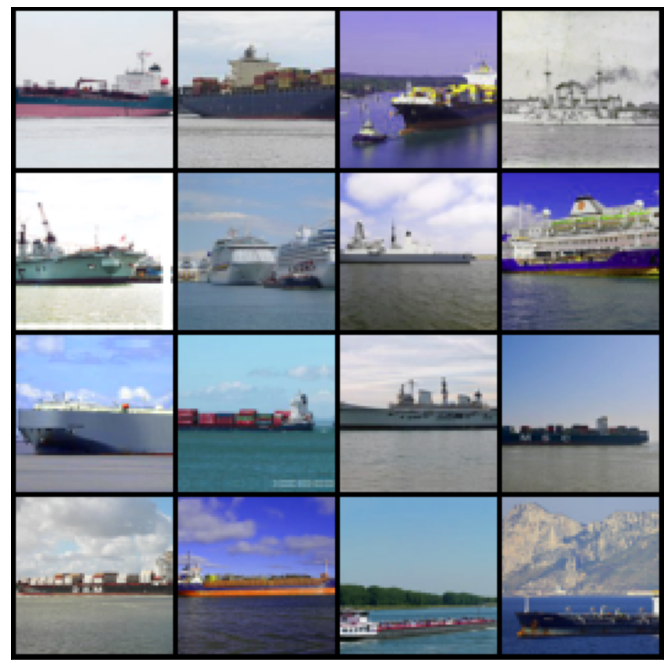

In [25]:
show_batch(train_dl)

In [26]:
jovian.commit()

[jovian] Detected Colab notebook...
[jovian] Uploading colab notebook to Jovian...
Committed successfully! https://jovian.ai/vijayraj-jain107130/dl-p-1


'https://jovian.ai/vijayraj-jain107130/dl-p-1'

###Moving the data to GPU

>Defining some helper functions and a class to move the data and model to the GPU.

In [27]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [28]:
device = get_default_device()
device

device(type='cuda')

Wrapping the training and validation data loaders using `DeviceDataLoader` for automatically transferring batches of data to the GPU (if available).

In [29]:
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)

##Defining the Model

>I'll use the ResNet9 architecture.

In [30]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))

In [31]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class ResNet9(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        
        self.conv1 = conv_block(in_channels, 64)
        self.conv2 = conv_block(64, 128, pool=True)
        self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))
        
        self.conv3 = conv_block(128, 256, pool=True)
        self.conv4 = conv_block(256, 512, pool=True)
        self.res2 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))
        
        self.classifier = nn.Sequential(nn.AdaptiveMaxPool2d(1), 
                                        nn.Flatten(), 
                                        nn.Dropout(0.2),
                                        nn.Linear(512, num_classes))
        
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out

In [48]:
model = to_device(ResNet9(3, 5), device)
model

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

Check if everything is setup correctly by passing one batch of data through the model.

In [33]:
torch.cuda.empty_cache()      #empty the cache

for batch in train_dl:
  imgs, labels = batch
  print('image size : ',imgs.shape)
  print('image device : ',imgs.device)
  preds = model(imgs)
  print('preds shape : ',preds.shape)
  break

image size :  torch.Size([128, 3, 64, 64])
image device :  cuda:0
preds shape :  torch.Size([128, 5])


###Train the Model

>Training the model by applying some regularization techniques like Learning Rate Scheduling, Weight Decay, Gradient Clipping.


In [34]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, 
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    
    # Set up cutom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(train_loader))
    
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            
            # Gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step()
            optimizer.zero_grad()
            
            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()
        
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [49]:
history = [evaluate(model, valid_dl)]
history

[{'val_acc': 0.1864352971315384, 'val_loss': 1.6078475713729858}]

Now the model is ready to be trained.

In [50]:
epochs = 8
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

history += fit_one_cycle(epochs, max_lr, model, train_dl, valid_dl, 
                         grad_clip=grad_clip, 
                         weight_decay=weight_decay, 
                         opt_func=opt_func)

Epoch [0], last_lr: 0.00388, train_loss: 1.6670, val_loss: 1.3082, val_acc: 0.4936
Epoch [1], last_lr: 0.00934, train_loss: 1.3691, val_loss: 3.8387, val_acc: 0.3666
Epoch [2], last_lr: 0.00972, train_loss: 1.5313, val_loss: 2.0607, val_acc: 0.3861
Epoch [3], last_lr: 0.00812, train_loss: 1.1801, val_loss: 1.0648, val_acc: 0.5837
Epoch [4], last_lr: 0.00556, train_loss: 1.0529, val_loss: 1.0353, val_acc: 0.5547
Epoch [5], last_lr: 0.00283, train_loss: 0.9085, val_loss: 0.7834, val_acc: 0.6873
Epoch [6], last_lr: 0.00077, train_loss: 0.7235, val_loss: 0.6624, val_acc: 0.7411
Epoch [7], last_lr: 0.00000, train_loss: 0.6245, val_loss: 0.5907, val_acc: 0.7741


In [51]:
epochs = 5
max_lr = 0.001
grad_clip = 0.001
weight_decay = 1e-6
opt_func = torch.optim.Adam

history += fit_one_cycle(epochs, max_lr, model, train_dl, valid_dl, 
                         grad_clip=grad_clip, 
                         weight_decay=weight_decay, 
                         opt_func=opt_func)

Epoch [0], last_lr: 0.00075, train_loss: 0.6286, val_loss: 0.6989, val_acc: 0.6991
Epoch [1], last_lr: 0.00095, train_loss: 0.6693, val_loss: 0.6326, val_acc: 0.7698
Epoch [2], last_lr: 0.00061, train_loss: 0.6048, val_loss: 0.5658, val_acc: 0.7888
Epoch [3], last_lr: 0.00019, train_loss: 0.5023, val_loss: 0.5019, val_acc: 0.8044
Epoch [4], last_lr: 0.00000, train_loss: 0.4577, val_loss: 0.4582, val_acc: 0.8152


Plotting the accuracies and losses to study the trend.

In [52]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

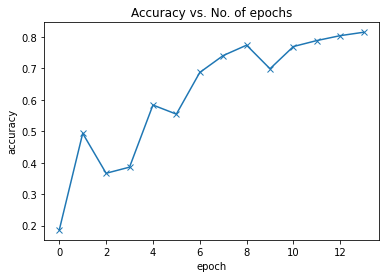

In [53]:
plot_accuracies(history)

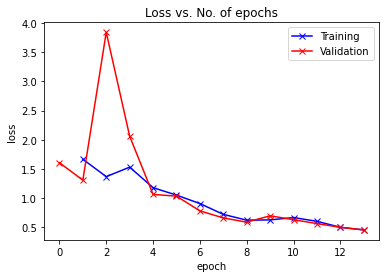

In [54]:
plot_losses(history)

###Testing the model
>Testing the model with individual images.

In [55]:
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return dataset.classes[preds[0].item()]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label: cruise , Predicted: cruise


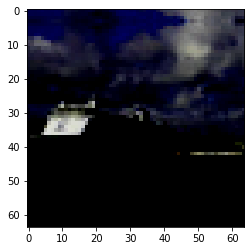

In [56]:
img, label = val_ds[102]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label: tanker , Predicted: tanker


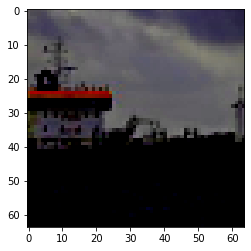

In [57]:
img, label = val_ds[12]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

In [58]:
history[-1]

{'lrs': [0.00018034913364880427,
  0.0001725729427488254,
  0.000164933009362544,
  0.00015743251279950787,
  0.00015007457434352067,
  0.00014286225595373865,
  0.0001357985589904568,
  0.00012888642296611104,
  0.00012212872432201962,
  0.00011552827523136959,
  0.00010908782242895002,
  0.00010281004606811448,
  9.669755860545345e-05,
  9.075290371363636e-05,
  8.49785552228792e-05,
  7.9376916091475e-05,
  7.395031740581898e-05,
  6.870101741034079e-05,
  6.363120056775158e-05,
  5.8742976649992996e-05,
  5.4038379860269074e-05,
  4.9519367986526286e-05,
  4.518782158673149e-05,
  4.104554320629086e-05,
  3.709425662793106e-05,
  3.33356061543587e-05,
  2.9771155923994307e-05,
  2.6402389260065633e-05,
  2.3230708053332355e-05,
  2.02574321786986e-05,
  1.7483798945954606e-05,
  1.491096258487895e-05,
  1.2539993764912554e-05,
  1.037187914960701e-05,
  8.407520986030097e-06,
  6.647736729302348e-06,
  5.09325870241742e-06,
  3.744733791491138e-06,
  2.6027231765636935e-06,
  1.667

###Log all the hyperparameters used

>Recording all the hyperparameters, losses and accuracy using `jovian` library.

In [59]:
jovian.log_dataset(image_size=64)

jovian.log_hyperparams(batch_size=128,
                       arch='ResNet9',
                       epochs=[8,5],
                       lrs='max:0.01,0.0001',
                       grad_clip = [0.01, 0.001],
                       weight_decay = [1e-4, 1e-6],
                       opt=['Adam', 'Adam'])

jovian.log_metrics(train_loss = history[-1]['train_loss'],
                   val_loss = history[-1]['val_loss'],
                   val_acc = history[-1]['val_acc'])

[jovian] Dataset logged.
[jovian] Hyperparams logged.
[jovian] Metrics logged.


In [60]:
jovian.commit()

[jovian] Detected Colab notebook...
[jovian] Uploading colab notebook to Jovian...
[jovian] Attaching records (metrics, hyperparameters, dataset etc.)
Committed successfully! https://jovian.ai/vijayraj-jain107130/dl-p-1


'https://jovian.ai/vijayraj-jain107130/dl-p-1'

In [47]:
# jovian.submit(assignment="zerotogans-project")